In [1]:
import sys
sys.path.insert(0, "timm_efficientdet-pytorch")
sys.path.insert(0, "omegaconf")
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
marking = pd.read_csv('../global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
marking.head

<bound method NDFrame.head of          image_id  width  height     source      x      y      w      h
0       b6ab77fd7   1024    1024    usask_1  834.0  222.0   56.0   36.0
1       b6ab77fd7   1024    1024    usask_1  226.0  548.0  130.0   58.0
2       b6ab77fd7   1024    1024    usask_1  377.0  504.0   74.0  160.0
3       b6ab77fd7   1024    1024    usask_1  834.0   95.0  109.0  107.0
4       b6ab77fd7   1024    1024    usask_1   26.0  144.0  124.0  117.0
...           ...    ...     ...        ...    ...    ...    ...    ...
147788  5e0747034   1024    1024  arvalis_2   64.0  619.0   84.0   95.0
147789  5e0747034   1024    1024  arvalis_2  292.0  549.0  107.0   82.0
147790  5e0747034   1024    1024  arvalis_2  134.0  228.0  141.0   71.0
147791  5e0747034   1024    1024  arvalis_2  430.0   13.0  184.0   79.0
147792  5e0747034   1024    1024  arvalis_2  875.0  740.0   94.0   61.0

[147793 rows x 8 columns]>

In [3]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0
print(df_folds.head)
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number
print(df_folds.head)

<bound method NDFrame.head of            bbox_count     source stratify_group  fold
image_id                                             
00333207f          55  arvalis_1    arvalis_1_3     0
005b0d8bb          20    usask_1      usask_1_1     0
006a994f7          25    inrae_1      inrae_1_1     0
00764ad5d          41    inrae_1      inrae_1_2     0
00b5fefed          25  arvalis_3    arvalis_3_1     0
...               ...        ...            ...   ...
ffb445410          57     rres_1       rres_1_3     0
ffbf75e5b          52  arvalis_1    arvalis_1_3     0
ffbfe7cc0          34  arvalis_1    arvalis_1_2     0
ffc870198          41    usask_1      usask_1_2     0
ffdf83e42          39  arvalis_1    arvalis_1_2     0

[3373 rows x 4 columns]>
<bound method NDFrame.head of            bbox_count     source stratify_group  fold
image_id                                             
00333207f          55  arvalis_1    arvalis_1_3     1
005b0d8bb          20    usask_1      usask_1_1   

/root/anaconda3/envs/detection/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [4]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5), # Crop a random part of the input and rescale it to (1024, 1024).
            A.OneOf([#Select one of transforms to apply with p=0.9
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),#Convert the input RGB image to grayscale. 
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),#Resize the input to the given height and width.
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc', #[x_min, y_min, x_max, y_max]
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [5]:
TRAIN_ROOT_PATH = '../global-wheat-detection/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes
    
    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [6]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

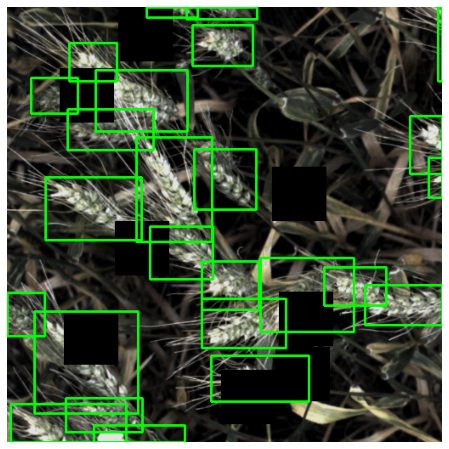

In [7]:
image, target, image_id = train_dataset[6]
boxes = target['boxes'].cpu().numpy().astype(np.int32)  # torch.float64 -> int32

numpy_image = image.permute(1,2,0).cpu().numpy() # torch.Size([3, 512, 512]), torch.float32 -> (512, 512, 3), float32

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')
    
    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                target_res = {} # added
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]
                
                target_res['bbox'] = boxes # added
                target_res['cls'] = labels # added
                target_res["scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device) #added
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)#added
                '''
                #add target_res
            target_res = {}
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res['bbox'] = boxes
            target_res['cls'] = labels 

            self.optimizer.zero_grad()
            
            #loss, _, _ = self.model(images, boxes, labels)
            output = self.model(images, target_res)
            loss = output['loss']
                '''
                #loss, _, _ = self.model(images, boxes, labels) command out
                output = self.model(images, target_res) #added
                loss = output['loss'] #added
                summary_loss.update(loss.detach().item(), batch_size)
                '''
                boxes = [target['boxes'].to(self.device).float() for target in targets]
labels = [target['labels'].to(self.device).float() for target in targets]

target_res = {}
target_res['bbox'] = boxes
target_res['cls'] = labels 
target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

outputs = self.model(images, target_res)
loss = outputs['loss']
                '''
        return summary_loss
    
    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            '''
            images: tuple, len = 4
            images[0].shape = torch.Size([3, 512, 512])
            images[0].dtype = torch.float32
            tensor([[[0.9891, 0.9732, 0.8689,  ..., 0.4343, 0.3783, 0.3970],
         [1.0000, 0.9493, 0.8044,  ..., 0.3474, 0.3755, 0.4297],
         [1.0000, 0.9530, 0.8110,  ..., 0.4175, 0.4745, 0.5278],
         ...
         [0.1017, 0.1110, 0.1185,  ..., 0.2362, 0.4147, 0.6147]]])
         -------------------------------------------------------------------   
            targets[0]
            labels.shape = torch.Size([31])
            {'boxes': tensor([[  5.7600,   0.0000,  66.5600,  44.1600],
        [  0.0000, 432.6400,   8.9600, 467.2000],
        [  0.0000, 454.4000,   2.5600, 496.6400],
        ...
        [209.9200, 385.9200, 254.0800, 497.2800]], dtype=torch.float64), 
        'labels': tensor([1, 1, 1, ..., 1]), 
        'image_id': tensor([75])}
            '''
            images = torch.stack(images)
            images = images.to(self.device).float()
            
            '''
            images: tuple, len = 4
            images[0].shape = torch.Size([3, 512, 512])
            images[0].dtype = torch.float32
            tensor([[[0.9891, 0.9732, 0.8689,  ..., 0.4343, 0.3783, 0.3970],
         [1.0000, 0.9493, 0.8044,  ..., 0.3474, 0.3755, 0.4297],
         [1.0000, 0.9530, 0.8110,  ..., 0.4175, 0.4745, 0.5278],
         ...,
         [0.1017, 0.1110, 0.1185,  ..., 0.2362, 0.4147, 0.6147]]])
            '''
            batch_size = images.shape[0]
            #add target_res
            target_res = {}
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res['bbox'] = boxes
            target_res['cls'] = labels 

            self.optimizer.zero_grad()
            
            #loss, _, _ = self.model(images, boxes, labels)
            output = self.model(images, target_res)
            loss = output['loss']
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss

    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')


In [10]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4 
    n_epochs = 60 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix-lr2'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    #device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [12]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('weights/tf_efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

In [13]:
run_training()

Fitter prepared. Device is cuda

2020-07-24T04:33:47.455421
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 1.82310, time: 571.09350
[RESULT]: Val. Epoch: 0, summary_loss: 0.47228, time: 32.98089

2020-07-24T04:43:52.773494
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.49706, time: 570.64289
[RESULT]: Val. Epoch: 1, summary_loss: 0.41291, time: 33.22203

2020-07-24T04:53:58.078883
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.46997, time: 566.52031
[RESULT]: Val. Epoch: 2, summary_loss: 0.40169, time: 31.29604

2020-07-24T05:04:00.082680
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.45717, time: 562.54656
[RESULT]: Val. Epoch: 3, summary_loss: 0.40075, time: 32.60430

2020-07-24T05:13:56.598033
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.45034, time: 566.51993
[RESULT]: Val. Epoch: 4, summary_loss: 0.39441, time: 34.09953

2020-07-24T05:24:01.269795
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.44472, time: 563.52022
[RESULT]: Val. Epoch: 5

[RESULT]: Val. Epoch: 47, summary_loss: 0.36063, time: 31.21767

2020-07-24T12:35:53.553885
LR: 2.44140625e-08
[RESULT]: Train. Epoch: 48, summary_loss: 0.37631, time: 573.84992
[RESULT]: Val. Epoch: 48, summary_loss: 0.36094, time: 31.74854

2020-07-24T12:46:02.933503
LR: 1.220703125e-08
[RESULT]: Train. Epoch: 49, summary_loss: 0.37672, time: 568.51108
[RESULT]: Val. Epoch: 49, summary_loss: 0.36115, time: 31.41624

2020-07-24T12:56:03.537235
LR: 1.220703125e-08
[RESULT]: Train. Epoch: 50, summary_loss: 0.37760, time: 574.21175
[RESULT]: Val. Epoch: 50, summary_loss: 0.36130, time: 32.32354

2020-07-24T13:06:10.824722
LR: 1.220703125e-08
[RESULT]: Train. Epoch: 51, summary_loss: 0.37556, time: 562.60145
[RESULT]: Val. Epoch: 51, summary_loss: 0.36082, time: 35.15972

2020-07-24T13:16:12.310258
LR: 1.220703125e-08
[RESULT]: Train. Epoch: 52, summary_loss: 0.37543, time: 566.37139
[RESULT]: Val. Epoch: 52, summary_loss: 0.36093, time: 32.20596

2020-07-24T13:26:11.568805
LR: 1.22070312